In [1]:
import pickle
import os
import urllib

import numpy as np
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA
import cv2

import torch
import torch.hub
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from tqdm import tqdm

DINOV3_GITHUB_LOCATION = "/hdd/side_projects/dinov3"

if os.getenv("DINOV3_LOCATION") is not None:
    DINOV3_LOCATION = os.getenv("DINOV3_LOCATION")
else:
    DINOV3_LOCATION = DINOV3_GITHUB_LOCATION

print(f"DINOv3 location set to {DINOV3_LOCATION}")

torch.hub.set_dir('/hdd/side_projects/dinov3/dinov3_models')

DINOv3 location set to /hdd/side_projects/dinov3


In [2]:
MODEL_DINOV3_VITS = "dinov3_vits16"
MODEL_DINOV3_VITSP = "dinov3_vits16plus"
MODEL_DINOV3_VITB = "dinov3_vitb16"
MODEL_DINOV3_VITL = "dinov3_vitl16"
MODEL_DINOV3_VITHP = "dinov3_vith16plus"
MODEL_DINOV3_VIT7B = "dinov3_vit7b16"

MODEL_NAME = MODEL_DINOV3_VITS

# Check PyTorch and CUDA compatibility
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    # Check compute capability
    try:
        compute_capability = torch.cuda.get_device_capability(0)
        print(f"Compute capability: {compute_capability[0]}.{compute_capability[1]}")
        if compute_capability[0] < 7:
            print("\n⚠️  WARNING: Your GPU has compute capability < 7.0")
            print("   PyTorch 2.0+ requires compute capability >= 7.0")
            print("   Solutions:")
            print("   1. Use CPU (slower but works)")
            print("   2. Install PyTorch 1.13.1 (last version supporting compute 6.1)")
            print("   3. Upgrade to a newer GPU")
    except:
        pass

# Determine if DINOV3_LOCATION is a local path or GitHub repo
# Local paths start with / (Linux/Mac) or contain :\ (Windows) or are absolute paths
# GitHub repos are in format "owner/repo"
is_local_path = (
    os.path.isabs(DINOV3_LOCATION) or 
    DINOV3_LOCATION.startswith('/') or 
    (os.name == 'nt' and ':\\' in DINOV3_LOCATION) or
    os.path.exists(DINOV3_LOCATION)
)
source = "local" if is_local_path else "github"

print(f"Loading model from: {DINOV3_LOCATION}")
print(f"Source type: {source}")

model = torch.hub.load(
    repo_or_dir=DINOV3_LOCATION,
    model=MODEL_NAME,
    source=source,
)

# Use CPU if CUDA is not compatible, otherwise use CUDA
USE_CPU = True  # Set to False if you have compatible PyTorch installed
if USE_CPU or not torch.cuda.is_available():
    device = torch.device('cpu')
    print(f"\nUsing device: CPU")
else:
    device = torch.device('cuda')
    print(f"\nUsing device: CUDA")
    
model = model.to(device)

PyTorch version: 2.9.1+cu128
CUDA available: True
CUDA version: 12.8
GPU: NVIDIA GeForce GTX 1070 Ti
Compute capability: 6.1

⚠️  WARNING: Your GPU has compute capability < 7.0
   PyTorch 2.0+ requires compute capability >= 7.0
   Solutions:
   1. Use CPU (slower but works)
   2. Install PyTorch 1.13.1 (last version supporting compute 6.1)
   3. Upgrade to a newer GPU
Loading model from: /hdd/side_projects/dinov3
Source type: local


/hdd/side_projects/bird_detection_project/py_env/lib/python3.12/site-packages/torch/cuda/__init__.py:283: UserWarning: 
    Found GPU0 NVIDIA GeForce GTX 1070 Ti which is of cuda capability 6.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (7.0) - (12.0)
    
  warnings.warn(
/hdd/side_projects/bird_detection_project/py_env/lib/python3.12/site-packages/torch/cuda/__init__.py:304: UserWarning: 
    Please install PyTorch with a following CUDA
    configurations:  12.6 following instructions at
    https://pytorch.org/get-started/locally/
    
  warnings.warn(matched_cuda_warn.format(matched_arches))
/hdd/side_projects/bird_detection_project/py_env/lib/python3.12/site-packages/torch/cuda/__init__.py:326: UserWarning: 
NVIDIA GeForce GTX 1070 Ti with CUDA capability sm_61 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_70 sm_75 sm_80 sm_86 sm_90 sm_100 sm_120.
If you want to use the N


Using device: CPU


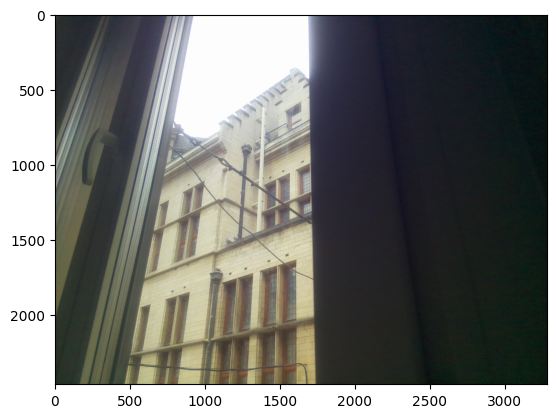

In [9]:
bird_images = "/media/niranjan/T7/bird_data_collection/20250802_212013"
image_name = "20250802_212132_0234.jpeg"
img = cv2.imread(os.path.join(bird_images, image_name))[:,:,::-1]
crop_params = [600, 1000, 1300, 1500] # crop_x, crop_y, crop_w, crop_h

img_cropped = img[crop_params[1]:crop_params[1]+crop_params[3], crop_params[0]:crop_params[0]+crop_params[2], :]

plt.imshow(img)

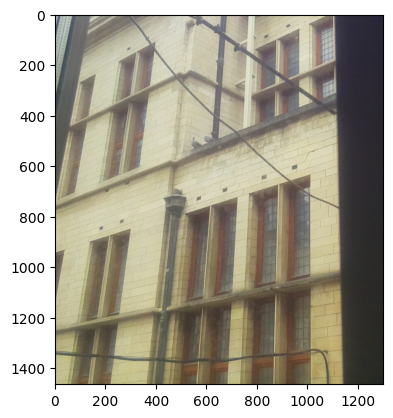

In [10]:
# crop the image 
cv2.imwrite("img_cropped.jpg", img_cropped[:,:,::-1])
plt.imshow(img_cropped)

In [13]:
print (img_cropped.shape)

(1464, 1300, 3)


Original position: (551, 521)
Resized position: (551, 462)
Patch coordinates: (34, 28)
Patch features shape: torch.Size([384, 81, 81])
Number of patches: 81 x 81
Cosine similarity map shape: torch.Size([81, 81])
Max similarity: 1.0000
Min similarity: 0.3085
Similarity at target patch (28, 34): 1.0000


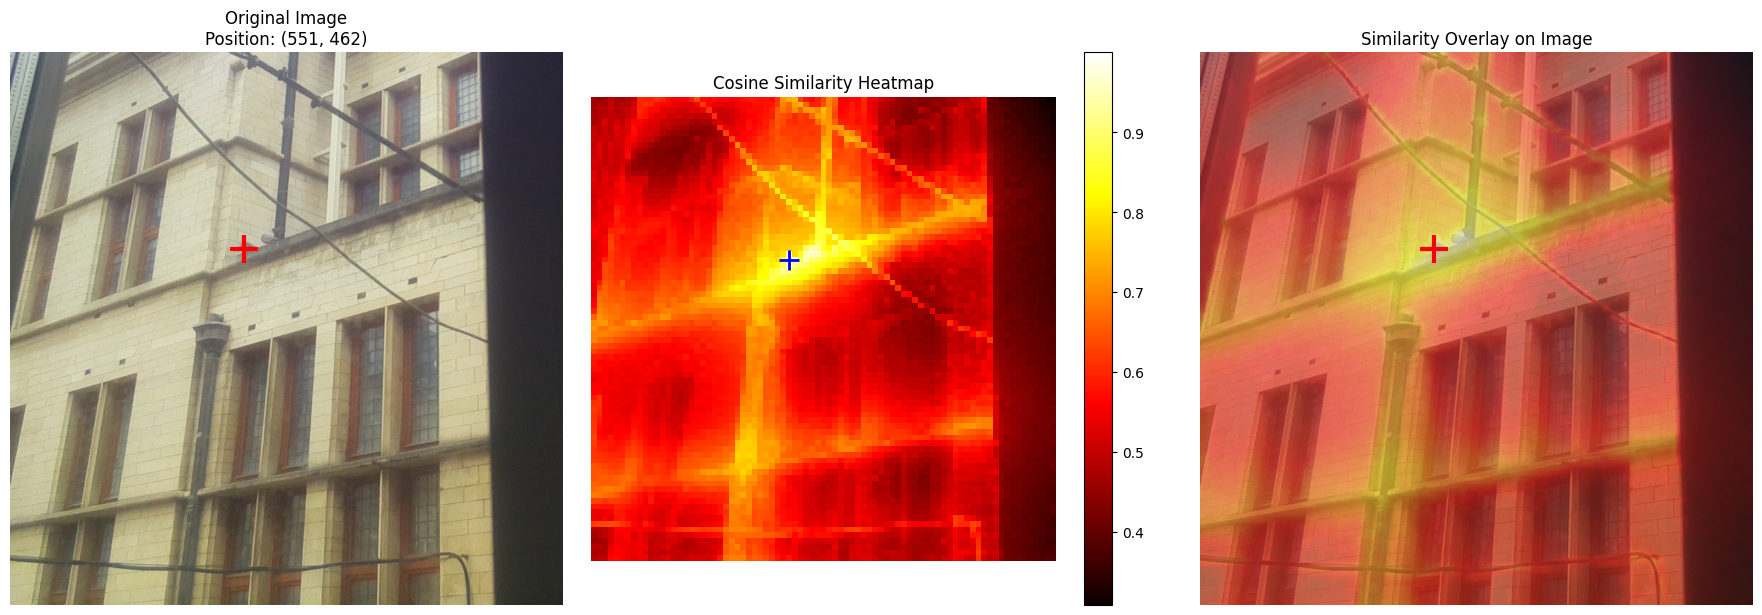


Top 10 most similar patches:
1. Patch (28, 34) -> Pixel (552, 456) -> resized pixel (552, 513), Similarity: 1.0000
2. Patch (28, 35) -> Pixel (568, 456) -> resized pixel (568, 513), Similarity: 0.9824
3. Patch (27, 38) -> Pixel (616, 440) -> resized pixel (616, 495), Similarity: 0.9642
4. Patch (29, 34) -> Pixel (552, 472) -> resized pixel (552, 531), Similarity: 0.9598
5. Patch (27, 37) -> Pixel (600, 440) -> resized pixel (600, 495), Similarity: 0.9530
6. Patch (27, 39) -> Pixel (632, 440) -> resized pixel (632, 495), Similarity: 0.9476
7. Patch (28, 37) -> Pixel (600, 456) -> resized pixel (600, 513), Similarity: 0.9455
8. Patch (27, 34) -> Pixel (552, 440) -> resized pixel (552, 495), Similarity: 0.9451
9. Patch (26, 38) -> Pixel (616, 424) -> resized pixel (616, 477), Similarity: 0.9447
10. Patch (30, 33) -> Pixel (536, 488) -> resized pixel (536, 549), Similarity: 0.9343


In [16]:
#Position x is 545 and y is 505

# resize the img_cropped image to 1024 and 1024. 
img_cropped_resized = cv2.resize(img_cropped, (1300, 1300))
# and use the dinov3 model to get the features for each patch. and use the position x and y to get the feature patch and do a cosine similarity with the other patches. 

# DINOv3 configuration
PATCH_SIZE = 16
IMAGE_SIZE = 1300
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

# Position in original cropped image (before resize)
pos_x_original = 551
pos_y_original = 521

# Calculate scale factor for position conversion
original_h, original_w = img_cropped.shape[:2]
scale_x = IMAGE_SIZE / original_w
scale_y = IMAGE_SIZE / original_h

# Convert position to resized image coordinates
pos_x = int(pos_x_original * scale_x)
pos_y = int(pos_y_original * scale_y)

# Convert pixel coordinates to patch coordinates
patch_x = pos_x // PATCH_SIZE
patch_y = pos_y // PATCH_SIZE

print(f"Original position: ({pos_x_original}, {pos_y_original})")
print(f"Resized position: ({pos_x}, {pos_y})")
print(f"Patch coordinates: ({patch_x}, {patch_y})")

# Convert image to PIL and prepare for model
img_pil = Image.fromarray(img_cropped_resized)
img_tensor = TF.to_tensor(img_pil)
img_tensor = TF.normalize(img_tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD)
img_tensor = img_tensor.unsqueeze(0).to(device)

# Extract features using DINOv3
MODEL_TO_NUM_LAYERS = {
    MODEL_DINOV3_VITS: 12,
    MODEL_DINOV3_VITSP: 12,
    MODEL_DINOV3_VITB: 12,
    MODEL_DINOV3_VITL: 24,
    MODEL_DINOV3_VITHP: 32,
    MODEL_DINOV3_VIT7B: 40,
}

n_layers = MODEL_TO_NUM_LAYERS[MODEL_NAME]

with torch.inference_mode():
    if device.type == 'cuda':
        with torch.autocast(device_type='cuda', dtype=torch.float32):
            # Extract features - shape will be [D, H, W] where H and W are patch dimensions
            feats = model.get_intermediate_layers(img_tensor, n=range(n_layers), reshape=True, norm=True)
            patch_features = feats[-1].squeeze().detach().cpu()  # Shape: [D, H_patches, W_patches]
    else:
        # CPU mode
        feats = model.get_intermediate_layers(img_tensor, n=range(n_layers), reshape=True, norm=True)
        patch_features = feats[-1].squeeze().detach().cpu()  # Shape: [D, H_patches, W_patches]

print(f"Patch features shape: {patch_features.shape}")
print(f"Number of patches: {patch_features.shape[1]} x {patch_features.shape[2]}")

# Extract the feature at the specified patch position
target_patch_feature = patch_features[:, patch_y, patch_x]  # Shape: [D]

# Normalize features for cosine similarity
patch_features_normalized = F.normalize(patch_features, p=2, dim=0)  # Normalize along feature dimension
target_patch_feature_normalized = F.normalize(target_patch_feature.unsqueeze(0), p=2, dim=1)  # Shape: [1, D]

# Compute cosine similarity with all patches using einsum
# patch_features_normalized: [D, H, W]
# target_patch_feature_normalized: [1, D]
# Result: [H, W]
cosine_similarity_map = torch.einsum(
    "d, d h w -> h w",
    target_patch_feature_normalized.squeeze(0),
    patch_features_normalized
)

print(f"Cosine similarity map shape: {cosine_similarity_map.shape}")
print(f"Max similarity: {cosine_similarity_map.max().item():.4f}")
print(f"Min similarity: {cosine_similarity_map.min().item():.4f}")
print(f"Similarity at target patch ({patch_y}, {patch_x}): {cosine_similarity_map[patch_y, patch_x].item():.4f}")

# Visualize the results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original image with position marked
axes[0].imshow(img_cropped_resized)
axes[0].plot(pos_x, pos_y, 'r+', markersize=20, markeredgewidth=3)
axes[0].set_title(f'Original Image\nPosition: ({pos_x}, {pos_y})')
axes[0].axis('off')

# Cosine similarity heatmap
im = axes[1].imshow(cosine_similarity_map.numpy(), cmap='hot', interpolation='nearest')
axes[1].plot(patch_x, patch_y, 'b+', markersize=15, markeredgewidth=2)
axes[1].set_title('Cosine Similarity Heatmap')
axes[1].axis('off')
plt.colorbar(im, ax=axes[1])

# Overlay similarity on image
axes[2].imshow(img_cropped_resized)
similarity_overlay = cosine_similarity_map.numpy()
similarity_resized = cv2.resize(similarity_overlay, (IMAGE_SIZE, IMAGE_SIZE))
axes[2].imshow(similarity_resized, cmap='hot', alpha=0.5, interpolation='nearest')
axes[2].plot(pos_x, pos_y, 'r+', markersize=20, markeredgewidth=3)
axes[2].set_title('Similarity Overlay on Image')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Get top-k most similar patches
k = 10
similarity_flat = cosine_similarity_map.flatten()
top_k_values, top_k_indices = torch.topk(similarity_flat, k)

# Convert flat indices to 2D patch coordinates
h_patches, w_patches = cosine_similarity_map.shape
top_k_patch_y = top_k_indices // w_patches
top_k_patch_x = top_k_indices % w_patches

print(f"\nTop {k} most similar patches:")
for i, (val, py, px) in enumerate(zip(top_k_values, top_k_patch_y, top_k_patch_x)):
    pixel_x = px.item() * PATCH_SIZE + PATCH_SIZE // 2
    pixel_y = py.item() * PATCH_SIZE + PATCH_SIZE // 2
    print(f"{i+1}. Patch ({py.item()}, {px.item()}) -> Pixel ({pixel_x}, {pixel_y}) -> resized pixel ({int(pixel_x*(1/scale_x))}, {int(pixel_y*(1/scale_y))}), Similarity: {val.item():.4f}")



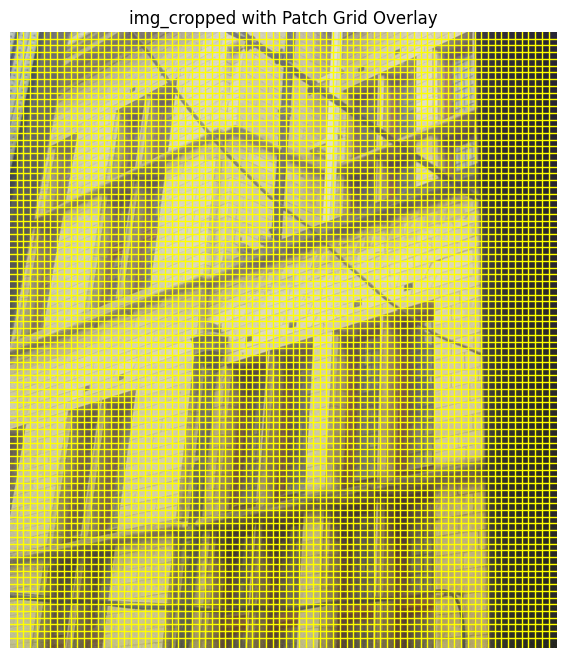

In [ ]:
# Display the grid of patches over img_cropped

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img_cropped)

n_rows = img_cropped.shape[0] // PATCH_SIZE
n_cols = img_cropped.shape[1] // PATCH_SIZE

# Draw horizontal grid lines
for y in range(1, n_rows):
    ax.axhline(y * PATCH_SIZE - 0.5, color='yellow', linewidth=1)

# Draw vertical grid lines
for x in range(1, n_cols):
    ax.axvline(x * PATCH_SIZE - 0.5, color='yellow', linewidth=1)

ax.set_title("img_cropped with Patch Grid Overlay")
ax.axis('off')
plt.show()





## CUDA Error Explanation

**Error**: `CUDA error: no kernel image is available for execution on the device`

**What it means**: 
- Your PyTorch installation was compiled for GPUs with compute capability >= 7.0
- Your GTX 1070 Ti has compute capability 6.1
- PyTorch doesn't have CUDA kernels compiled for your GPU architecture

**Solutions**:

### Option 1: Use CPU (Current Workaround)
The code above is now set to use CPU. It will be slower but will work.

### Option 2: Install PyTorch 1.13.1 (Recommended for GPU)
PyTorch 1.13.1 is the last version that supports compute capability 6.1:

```bash
# In your virtual environment
pip uninstall torch torchvision torchaudio
pip install torch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1 --index-url https://download.pytorch.org/whl/cu117
```

Then set `USE_CPU = False` in the cell above.

### Option 3: Use PyTorch 2.0 with CPU-only build
```bash
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
```

**Note**: DINOv3 models can run on CPU, but inference will be significantly slower (10-100x depending on model size).
